# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 28/03/2024

In [1]:
# USER: Change the path below to point to your local copy of ImageD11:

import os

home_dir = !echo $HOME
home_dir = str(home_dir[0])

# USER: You can change this location if you want

id11_code_path = os.path.join(home_dir, "Code/ImageD11")

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os
import concurrent.futures
import timeit

import matplotlib
%matplotlib ipympl

import h5py
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from xfab.symmetry import Umis

import ImageD11.columnfile
from ImageD11.peakselect import select_ring_peaks_by_intensity
from ImageD11.sinograms import properties, roi_iradon
from ImageD11.sinograms import geometry
from ImageD11.sinograms.sinogram import GrainSinogram, build_slice_arrays, write_slice_recon, read_slice_recon, write_h5, read_h5
from ImageD11.grain import grain
from ImageD11 import cImageD11

import ImageD11.nbGui.nb_utils as utils

In [3]:
# NOTE: Change the below flag to false if you want to process your own data other than the test:

run_test_data = True

In [4]:
if run_test_data:
    sample = 'Si_cube'
    dataset = 'S3DXRD_nt_moves_dty'
    
    dset_file = os.path.join(id11_code_path, 'test', sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
    ds = ImageD11.sinograms.dataset.load(dset_file)

In [5]:
# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA

### USER: specify your experimental directory

if not run_test_data:
    rawdata_path = "/data/visitor/blc15312/id11/20240409/RAW_DATA"

    !ls -lrt {rawdata_path}

    ### USER: specify where you want your processed data to go

    processed_data_root_dir = "/data/visitor/blc15312/id11/20240409/PROCESSED_DATA"

In [6]:
# USER: pick a sample and a dataset you want to segment

sample = 'Si_cube'
dataset = 'S3DXRD_nt_moves_dty'

In [7]:
# desination of H5 files
if not run_test_data:
    dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

In [8]:
# Load the dataset
if not run_test_data:
    ds = ImageD11.sinograms.dataset.load(dset_path)

In [9]:
# Import 2D peaks

cf_2d = ds.get_cf_2d_from_disk()
cf_2d.parameters.loadparameters(ds.parfile)
cf_2d.updateGeometry()

print(f"Read {cf_2d.nrows} 2D peaks")

Reading your columnfile in hdf format
Read 9134 2D peaks


In [10]:
# import grainsinos

grainsinos = read_h5(ds.grainsfile, ds)
grains = [gs.grain for gs in grainsinos]

In [11]:
# import slice reconstructions

slice_arrays = read_slice_recon(ds.grainsfile)
rgb_x_array, rgb_y_array, rgb_z_array, grain_labels_array, raw_intensity_array = slice_arrays

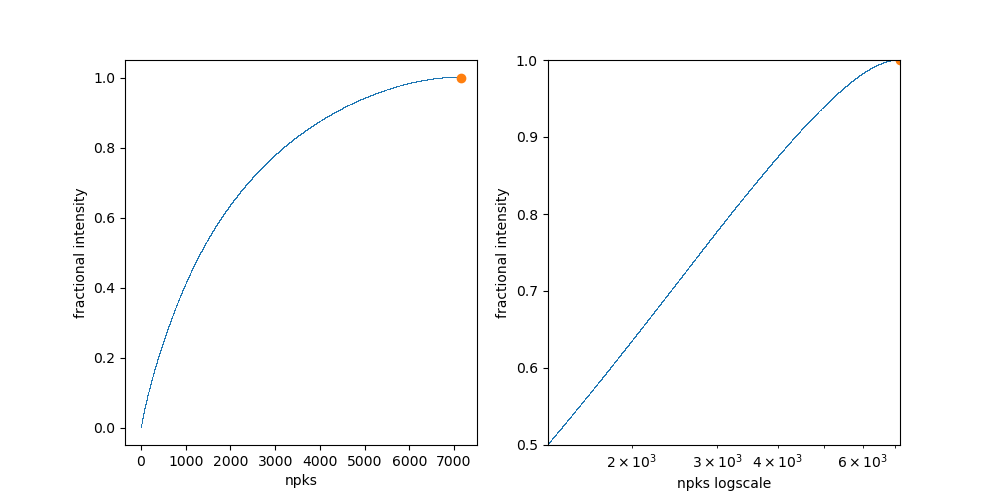

9134
7160


In [12]:
# filter 2D peaks by intensity

cf_2d_strong_frac = 1.0

cf_2d_strong = select_ring_peaks_by_intensity(cf_2d, frac=cf_2d_strong_frac, dsmax=cf_2d.ds.max(), doplot=0.5)
print(cf_2d.nrows)
print(cf_2d_strong.nrows)

In [13]:
y0 = grainsinos[0].recon_y0
recon_shape = grainsinos[0].recons["mlem"].shape

In [14]:
dtyi = geometry.dty_to_dtyi(cf_2d_strong.dty, ystep=ds.ystep)

cf_2d_strong.addcolumn(dtyi, "dtyi")

In [15]:
peak_assign_tol = 0.025

utils.assign_peaks_to_grains(grains, cf_2d_strong, tol=peak_assign_tol)

print("Storing peak data in grains")
# iterate through all the grains

gvecs_2d_strong = np.transpose((cf_2d_strong.gx, cf_2d_strong.gy, cf_2d_strong.gz)).astype(float)

# make lookup table for grain IDs so we can quickly get the grain given a GID (might not be contiguous or start at 0)
grain_lut = {}
for inc, g in enumerate(tqdm(grains)):
    grain_lut[inc] = g
    g.mask_2d_strong = cf_2d_strong.grain_id == inc
    
    g.gve_2d_strong = gvecs_2d_strong[g.mask_2d_strong].T
    
    g.omega = cf_2d_strong.omega[g.mask_2d_strong]
    g.dty = cf_2d_strong.dty[g.mask_2d_strong]
    g.dtyi = cf_2d_strong.dtyi[g.mask_2d_strong]
    g.label_mask = grain_labels_array == inc

Scoring and assigning 1 grains


  0%|          | 0/1 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# refine each grain's ubi using all contributory pixels
# use the tolerance we used for assignment earlier

for grain in tqdm(grains):

    ubifit = grain.ubi.copy()
    _ = cImageD11.score_and_refine(ubifit, np.transpose(grain.gve_2d_strong), peak_assign_tol)
    
    grain.set_ubi(ubifit)

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# WORKING

# for each grain
# for each pixel in the mask
# local refinement
# global container

n_ysteps_tol = 10

per_pixel_ubis = {}

nthreads = len(os.sched_getaffinity(os.getpid()))

for ginc, grain in enumerate(tqdm(grains[:])):
    def refine_ubis(pixel_position):
        ri, rj = pixel_position
        
        # get a mask of the 2D peaks for this grain at this pixel only
        mask = geometry.dtyimask_from_recon(ri, rj, grain.omega, grain.dtyi, recon_shape=recon_shape, ystep=ds.ystep, y0=y0)
        
        gve = np.transpose(grain.gve_2d_strong[:, mask])
        
        ubifit = grain.ubi.copy()
        _ = cImageD11.score_and_refine(ubifit, gve, peak_assign_tol)

        return ubifit

    pixel_positions = np.argwhere(grain.label_mask == True)
    
    with concurrent.futures.ThreadPoolExecutor(max_workers = max(1, nthreads-1)) as pool:
        pixel_ubis = pool.map(refine_ubis, pixel_positions)

    for pixel_position, ubi in zip(pixel_positions, pixel_ubis):
        per_pixel_ubis[tuple(pixel_position)] = (ginc, ubi)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
# determine a UBI per pixel

ubi_map = np.empty((recon_shape + (3,3)))
ubi_map.fill(np.nan)
for pxi in tqdm(range(recon_shape[0])):
    for pxj in range(recon_shape[1]):
        try:
            graininc, this_ubi = per_pixel_ubis[pxi, pxj]
            ubi_map[pxi, pxj, :, :] = this_ubi
        except KeyError:
            continue

  0%|          | 0/41 [00:00<?, ?it/s]

In [20]:
cf_pars = cf_2d_strong.parameters.get_parameters()
spacegroup = 227  # spacegroup for BCC iron
cf_pars["cell_lattice_[P,A,B,C,I,F,R]"] = spacegroup

ref_ucell = ImageD11.unitcell.unitcell_from_parameters(cf_pars)

pixel_grain_lut = {}
for i in tqdm(range(recon_shape[0])):
    for j in range(recon_shape[1]):
        this_ubi = ubi_map[i, j]
        if not np.isnan(this_ubi[0,0]):
            this_grain = ImageD11.grain.grain(this_ubi)
            this_grain.ref_unitcell = ref_ucell
            pixel_grain_lut[i, j] = this_grain

  0%|          | 0/41 [00:00<?, ?it/s]

In [21]:
eps_map = np.empty((recon_shape + (3,3)))
eps_map.fill(np.nan)
for i in tqdm(range(recon_shape[0])):
    for j in range(recon_shape[1]):
        try:
            this_grain = pixel_grain_lut[i, j]
            this_ref_gid = grain_labels_array[i, j]
            this_ref_grain = grain_lut[this_ref_gid]
            this_eps = this_grain.eps_sample_matrix(dzero_cell=this_ref_grain.unitcell)
            eps_map[i, j] = this_eps
        except KeyError:
            continue

  0%|          | 0/41 [00:00<?, ?it/s]

In [22]:
misorientation_map = np.empty((recon_shape))
misorientation_map.fill(np.nan)
for i in tqdm(range(recon_shape[0])):
    for j in range(recon_shape[1]):
        try:
            this_grain = pixel_grain_lut[i, j]
            this_ref_gid = grain_labels_array[i, j]
            this_ref_grain = grain_lut[this_ref_gid]
            this_misorien = np.min(Umis(this_ref_grain.U, this_grain.U, 7), axis=0)[1]
            misorientation_map[i, j] = this_misorien
        except KeyError:
            continue

  0%|          | 0/41 [00:00<?, ?it/s]

In [23]:
# build an array of UB matrices that doesn't contain NANs

indices_no_nan = []

ubis_flat = ubi_map.reshape(recon_shape[0] * recon_shape[1], 3, 3)

ubs_flat = []

for index, ubi in enumerate(ubis_flat):
    # ensure the entire UBI is not NAN:
    if not np.isnan(ubi).any():
        ub = np.linalg.inv(ubi)
        ubs_flat.append(ub)
        indices_no_nan.append(index)

ubs_flat = np.array(ubs_flat)
indices_no_nan = np.array(indices_no_nan)

assert not np.isnan(ubs_flat).any()

In [24]:
# determine IPF colours
# get an orix orientation for all the grains

orix_orien = ref_ucell.get_orix_orien(ubs_flat)

ipf_x_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([1., 0., 0.]))
ipf_y_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([0., 1., 0.]))
ipf_z_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([0., 0., 1.]))

In [25]:
# repopulate IPF colours

ipf_x_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))
ipf_y_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))
ipf_z_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))

pointer = 0

for index in range(ipf_x_map_flat.shape[0]):
    if index in indices_no_nan:
        # UBI was not NAN
        ipf_x_map_flat[index] = ipf_x_flat[pointer]
        ipf_y_map_flat[index] = ipf_y_flat[pointer]
        ipf_z_map_flat[index] = ipf_z_flat[pointer]
        pointer += 1

ipf_x_col_map = ipf_x_map_flat.reshape(recon_shape + (3,))
ipf_y_col_map = ipf_y_map_flat.reshape(recon_shape + (3,))
ipf_z_col_map = ipf_z_map_flat.reshape(recon_shape + (3,))

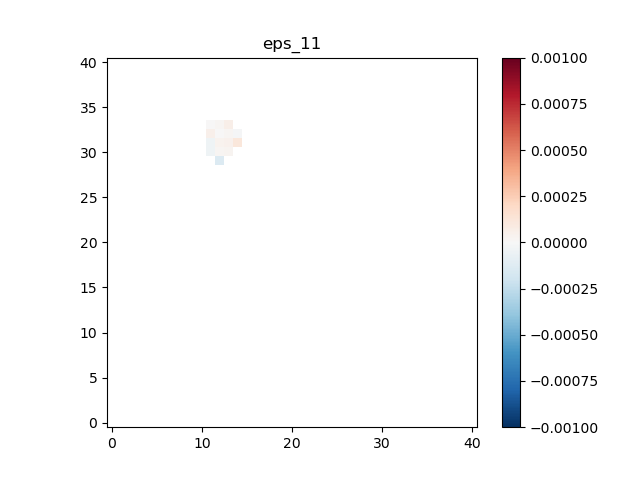

In [26]:
eps_s_11_map = eps_map[:, :, 0, 0]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_11_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3, origin="lower")
plt.colorbar(im)
ax.set_title("eps_11")
plt.show()

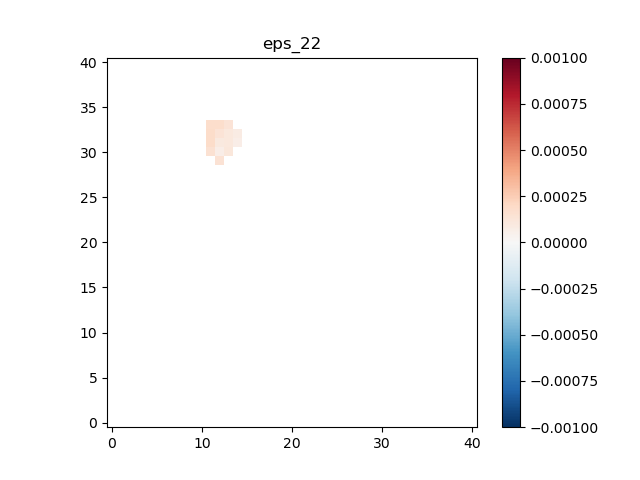

In [27]:
eps_s_22_map = eps_map[:, :, 1, 1]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_22_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3, origin="lower")
plt.colorbar(im)
ax.set_title("eps_22")
plt.show()

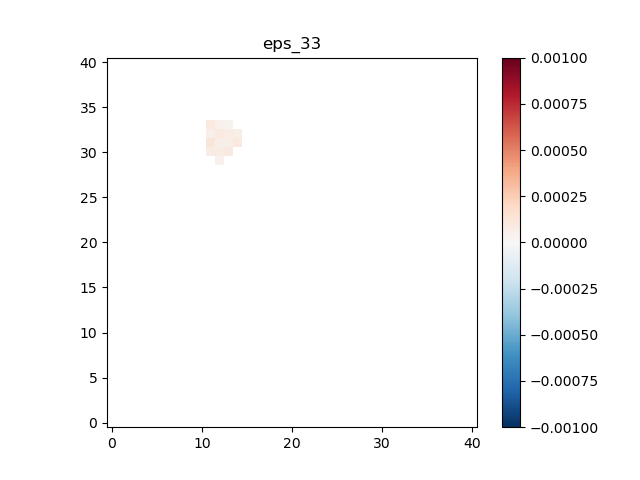

In [28]:
eps_s_33_map = eps_map[:, :, 2, 2]

fig, ax = plt.subplots()
im = ax.imshow(eps_s_33_map, cmap='RdBu_r', vmin=-1e-3, vmax=1e-3, origin="lower")
plt.colorbar(im)
ax.set_title("eps_33")
plt.show()

# add quivers!!!

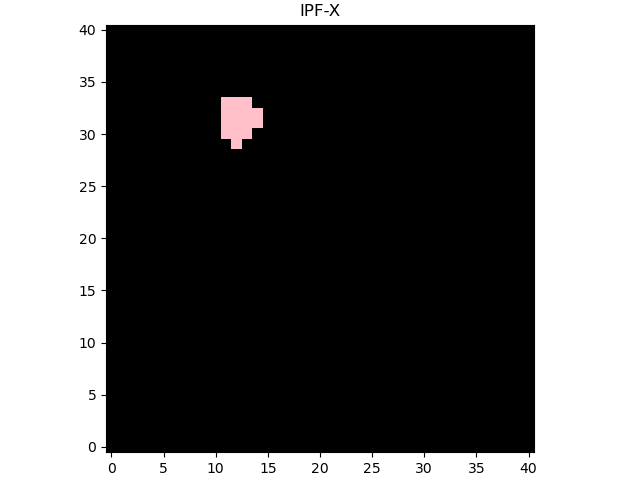

In [29]:
image_to_show = np.transpose((ipf_x_col_map[:, :, 0], ipf_x_col_map[:, :, 1], ipf_x_col_map[:, :, 2]), axes=(1, 2, 0))
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image_to_show, origin="lower")  # originally 1,2,0
ax.set_title("IPF-X")
plt.show()

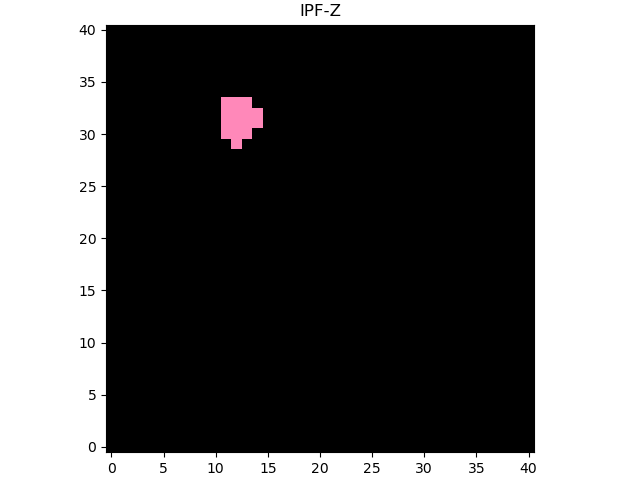

In [30]:
image_to_show = np.transpose((ipf_z_col_map[:, :, 0], ipf_z_col_map[:, :, 1], ipf_z_col_map[:, :, 2]), axes=(1, 2, 0))
fig, ax = plt.subplots(constrained_layout=True)
ax.imshow(image_to_show, origin="lower")  # originally 1,2,0
ax.set_title("IPF-Z")
plt.show()

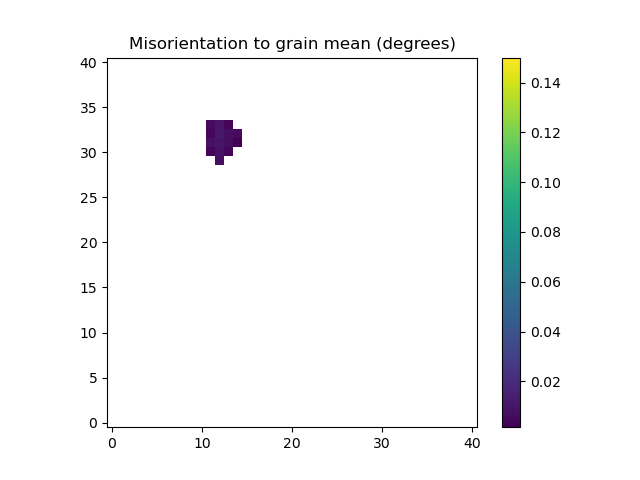

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(misorientation_map, vmax=0.15, origin="lower")
plt.colorbar(im)
ax.set_title("Misorientation to grain mean (degrees)")
plt.show()

In [32]:
ds.pbpubifile = os.path.join(ds.analysispath, ds.dsname + '_pbp_map.h5')

In [33]:
utils.save_ubi_map(ds, ubi_map, eps_map, misorientation_map, ipf_x_col_map, ipf_y_col_map, ipf_z_col_map)

In [34]:
ds.save()

In [ ]:
if 1:
    raise ValueError("Change the 1 above to 0 to allow 'Run all cells' in the notebook")

In [ ]:
# Now that we're happy with our indexing parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(rawdata_path, skips_dict, dset_prefix, sample_list)
    
# manual override:
samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_200um"]}
    
# now we have our samples_dict, we can process our data:

nthreads = len(os.sched_getaffinity(os.getpid()))

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        
        if not os.path.exists(ds.grainsfile):
            print(f"Missing grains file for {dataset} in sample {sample}, skipping")
            continue
            
        ds.pbpubifile = os.path.join(ds.analysispath, ds.dsname + '_pbp_map.h5')
            
        if os.path.exists(ds.pbpubifile):
            print(f"PBP file already exists for {dataset} in sample {sample}, skipping")
            continue

        cf_2d = ds.get_cf_2d_from_disk()
        cf_2d.parameters.loadparameters(ds.parfile)
        cf_2d.updateGeometry()
        
        grainsinos = read_h5(ds.grainsfile, ds)
        grains = [gs.grain for gs in grainsinos]
        
        slice_arrays = read_slice_recon(ds.grainsfile)
        rgb_x_array, rgb_y_array, rgb_z_array, grain_labels_array, raw_intensity_array = slice_arrays
        
        cf_2d_strong = select_ring_peaks_by_intensity(cf_2d, frac=cf_2d_strong_frac, dsmax=cf_2d.ds.max())
        y0 = grainsinos[0].recon_y0
        recon_shape = grainsinos[0].recons["mlem"].shape

        dtyi = geometry.dty_to_dtyi(cf_2d_strong.dty, ystep=ds.ystep)
        cf_2d_strong.addcolumn(dtyi, "dtyi")
        
        utils.assign_peaks_to_grains(grains, cf_2d_strong, tol=peak_assign_tol)

        print("Storing peak data in grains")
        # iterate through all the grains

        gvecs_2d_strong = np.transpose((cf_2d_strong.gx, cf_2d_strong.gy, cf_2d_strong.gz)).astype(float)

        # make lookup table for grain IDs so we can quickly get the grain given a GID (might not be contiguous or start at 0)
        grain_lut = {}
        for inc, g in enumerate(tqdm(grains)):
            grain_lut[inc] = g
            g.mask_2d_strong = cf_2d_strong.grain_id == inc

            g.gve_2d_strong = gvecs_2d_strong[g.mask_2d_strong].T

            g.omega = cf_2d_strong.omega[g.mask_2d_strong]
            g.dty = cf_2d_strong.dty[g.mask_2d_strong]
            g.dtyi = cf_2d_strong.dtyi[g.mask_2d_strong]
            g.label_mask = grain_labels_array == inc
            
            ubifit = g.ubi.copy()
            _ = cImageD11.score_and_refine(ubifit, np.transpose(g.gve_2d_strong), peak_assign_tol)
            g.set_ubi(ubifit)
        
        per_pixel_ubis = {}
        
        for ginc, grain in enumerate(tqdm(grains[:])):
            def refine_ubis(pixel_position):
                ri, rj = pixel_position
        
                mask = geometry.dtyimask_from_recon(ri, rj, grain.omega, grain.dtyi, recon_shape=recon_shape, ystep=ds.ystep, y0=y0)

                gve = np.transpose(grain.gve_2d_strong[:, mask])

                ubifit = grain.ubi.copy()
                _ = cImageD11.score_and_refine(ubifit, gve, peak_assign_tol)

                return ubifit

            pixel_positions = np.argwhere(grain.label_mask == True)

            with concurrent.futures.ThreadPoolExecutor(max_workers = max(1, nthreads-1)) as pool:
                pixel_ubis = pool.map(refine_ubis, pixel_positions)

            for pixel_position, ubi in zip(pixel_positions, pixel_ubis):
                per_pixel_ubis[tuple(pixel_position)] = (ginc, ubi)

        ubi_map = np.empty((recon_shape + (3,3)))
        ubi_map.fill(np.nan)
        for pxi in tqdm(range(recon_shape[0])):
            for pxj in range(recon_shape[1]):
                try:
                    graininc, this_ubi = per_pixel_ubis[pxi, pxj]
                    ubi_map[pxi, pxj, :, :] = this_ubi
                except KeyError:
                    continue
                    
        pixel_grain_lut = {}
        for i in tqdm(range(recon_shape[0])):
            for j in range(recon_shape[1]):
                this_ubi = ubi_map[i, j]
                if not np.isnan(this_ubi[0,0]):
                    this_grain = ImageD11.grain.grain(this_ubi)
                    this_grain.ref_unitcell = ref_ucell
                    pixel_grain_lut[i, j] = this_grain
                    
        eps_map = np.empty((recon_shape + (3,3)))
        eps_map.fill(np.nan)
        for i in tqdm(range(recon_shape[0])):
            for j in range(recon_shape[1]):
                try:
                    this_grain = pixel_grain_lut[i, j]
                    this_ref_gid = grain_labels_array[i, j]
                    this_ref_grain = grain_lut[this_ref_gid]
                    this_eps = this_grain.eps_sample_matrix(dzero_cell=this_ref_grain.unitcell)
                    eps_map[i, j] = this_eps
                except KeyError:
                    continue

        misorientation_map = np.empty((recon_shape))
        misorientation_map.fill(np.nan)
        for i in tqdm(range(recon_shape[0])):
            for j in range(recon_shape[1]):
                try:
                    this_grain = pixel_grain_lut[i, j]
                    this_ref_gid = grain_labels_array[i, j]
                    this_ref_grain = grain_lut[this_ref_gid]
                    this_misorien = np.min(Umis(this_ref_grain.U, this_grain.U, 7), axis=0)[1]
                    misorientation_map[i, j] = this_misorien
                except KeyError:
                    continue
        
        indices_no_nan = []
        ubis_flat = ubi_map.reshape(recon_shape[0] * recon_shape[1], 3, 3)
        ubs_flat = []
        for index, ubi in enumerate(ubis_flat):
            if not np.isnan(ubi).any():
                ub = np.linalg.inv(ubi)
                ubs_flat.append(ub)
                indices_no_nan.append(index)
        ubs_flat = np.array(ubs_flat)
        indices_no_nan = np.array(indices_no_nan)
        orix_orien = ref_ucell.get_orix_orien(ubs_flat)
        ipf_x_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([1., 0., 0.]))
        ipf_y_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([0., 1., 0.]))
        ipf_z_flat = ref_ucell.get_ipf_colour_from_orix_orien(orix_orien, axis=np.array([0., 0., 1.]))
        ipf_x_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))
        ipf_y_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))
        ipf_z_map_flat = np.zeros((recon_shape[0] * recon_shape[1], 3))
        pointer = 0
        for index in range(ipf_x_map_flat.shape[0]):
            if index in indices_no_nan:
                # UBI was not NAN
                ipf_x_map_flat[index] = ipf_x_flat[pointer]
                ipf_y_map_flat[index] = ipf_y_flat[pointer]
                ipf_z_map_flat[index] = ipf_z_flat[pointer]
                pointer += 1
        ipf_x_col_map = ipf_x_map_flat.reshape(recon_shape + (3,))
        ipf_y_col_map = ipf_y_map_flat.reshape(recon_shape + (3,))
        ipf_z_col_map = ipf_z_map_flat.reshape(recon_shape + (3,))
        
        utils.save_ubi_map(ds, ubi_map, eps_map, misorientation_map, ipf_x_col_map, ipf_y_col_map, ipf_z_col_map)
        ds.save()

print("Done!")